# POC to analyze ALB logs and show case
    - Anomaly Detection for status code, number of request
    - To Train a model to detect threat using logs properties
    - To Check if the model is able to answer threat label based on properties  

Query to get status from alb for 4 days

```
SELECT 
extract(day FROM parse_datetime(time,'yyyy-MM-dd''T''HH:mm:ss.SSSSSS''Z')) as day,
extract(HOUR FROM parse_datetime(time,'yyyy-MM-dd''T''HH:mm:ss.SSSSSS''Z')) as hour,
sum(case when "elb_status_code"  between 200 and 299 then 1 else 0 end) as "2xx",
sum(case when "elb_status_code"  between 300 and 399 then 1 else 0 end) as "3xx",
sum(case when "elb_status_code"  between 400 and 499 then 1 else 0 end) as "4xx",
sum(case when "elb_status_code"  > 499 then 1 else 0 end) as "5xx"
FROM "alb_db"."alb_logs"
where "day" in ('2023/07/09','2023/07/08','2023/07/07','2023/07/06') 
group by extract(day FROM parse_datetime(time,'yyyy-MM-dd''T''HH:mm:ss.SSSSSS''Z')),extract(HOUR FROM parse_datetime(time,'yyyy-MM-dd''T''HH:mm:ss.SSSSSS''Z'))
order by 1 ASC,2 ASC
```

In [1]:
# To import csv with status code
import pandas as pd
status_df = pd.read_csv('aggregates/status_code_aggregates.csv')
status_df['day'] = status_df['day'].astype(str)
status_df['hour'] = status_df['hour'].astype(str)
status_df.describe()

,2xx,3xx,4xx,5xx
count,97.000000,97.000000,97.000000,97.000000
mean,112383.247423,125860.000000,2650.721649,3571.144330
std,61987.912810,83804.691078,1832.295667,1641.074807
min,1811.000000,1324.000000,10.000000,72.000000
25%,50387.000000,34177.000000,791.000000,1899.000000
50%,122186.000000,138460.000000,2702.000000,4135.000000
75%,166766.000000,210746.000000,3960.000000,5029.000000
max,214009.000000,217261.000000,7225.000000,5967.000000


In [2]:
# Describe status df
from pandas import to_datetime
def add_padding(val):
    if int(val) < 10:
        return f"0{str(val)}"
    return str(val)


status_df['ds'] = "2023-07-"+status_df['day'].apply(add_padding)+" "+status_df['hour'].apply(add_padding)+":00:00"
status_df['ds'] = to_datetime(status_df['ds'])
status_df.head()


,day,hour,2xx,3xx,4xx,5xx,ds
0,5,23,1811,1324,10,72,2023-07-05 23:00:00
1,6,0,24539,15619,178,1150,2023-07-06 00:00:00
2,6,1,30420,17493,199,1340,2023-07-06 01:00:00
3,6,2,40499,19013,201,1808,2023-07-06 02:00:00
4,6,3,56962,35519,446,2118,2023-07-06 03:00:00


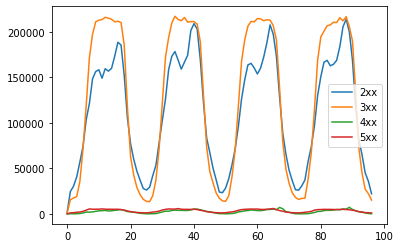

In [3]:
from matplotlib import pyplot
status_df[["2xx","3xx","4xx","5xx"]].plot()
pyplot.show()

In [4]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)


/Users/shubhamnegi/Documents/python_workspace/alb-to-influx/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Prophet 0.7.1


In [5]:
# train model using actual data for 200
from fbprophet import Prophet
prop_df_2xx  = pd.DataFrame(columns=['ds','y'])
prop_df_2xx['ds']  = status_df['ds']
prop_df_2xx['y']  = status_df['2xx']
prop_df_2xx.shape
model = Prophet()
model.fit(prop_df_2xx)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


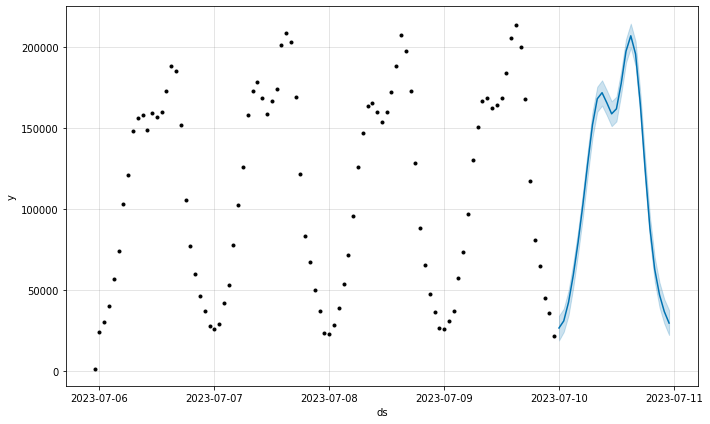

In [6]:
# now lets show prediction for 10th july
future_2xx = list()
for i in range(0, 24):
	date = f"2023-07-10 {add_padding(i)}:00:00"
	future_2xx.append([date])

future_2xx = pd.DataFrame(future_2xx)
future_2xx.head()
future_2xx.columns = ['ds']
future_2xx['ds']= to_datetime(future_2xx['ds'])
future_2xx.head()
forecast = model.predict(future_2xx)
model.plot(forecast)
pyplot.show()



## In the above diagram we saw how we can predict data for a future data for 2xx status, Now let check if the prediction match with real data
To show case this we will 
- Remove data for 2023-07-09 from the data frame
- Train data based on 2023-07-06, 2023-07-07, 2023-07-08
- Plot real and predicted data

In [7]:
# Here we dont have date for 2023-07-09
train_2xx_train = prop_df_2xx[prop_df_2xx['ds'] < pd.to_datetime("2023-07-09 00:00:00")]
train_2xx_train.tail()

,ds,y
68,2023-07-08 19:00:00,88807
69,2023-07-08 20:00:00,65577
70,2023-07-08 21:00:00,47951
71,2023-07-08 22:00:00,36539
72,2023-07-08 23:00:00,26607


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Mean diff = 1597.4593802225106


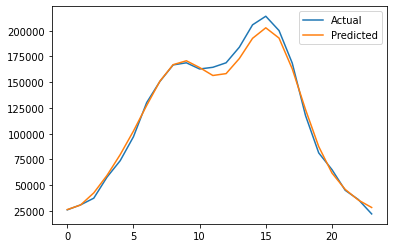

In [13]:
# Let predict values for 9th

future_2xx_9thJuly = list()
for i in range(0, 24):
	date = f"2023-07-09 {add_padding(i)}:00:00"
	future_2xx_9thJuly.append([date])

future_2xx_9thJuly = pd.DataFrame(future_2xx_9thJuly)
future_2xx_9thJuly.head()
future_2xx_9thJuly.columns = ['ds']
future_2xx_9thJuly['ds']= to_datetime(future_2xx_9thJuly['ds'])
future_2xx_9thJuly.head()

model = Prophet() # create new object for training
model.fit(train_2xx_train) # train using 3 days data
forecast = model.predict(future_2xx_9thJuly) # predict for 9th july
y_true = prop_df_2xx[prop_df_2xx['ds'] >= pd.to_datetime("2023-07-09 00:00:00") ]['y'].values
y_pred = forecast['yhat'].values

sum_of_diff = 0
for i in range(0,23):
	diff = y_true[i] - y_pred[i]
	sum_of_diff = sum_of_diff + diff
	
print(f"Mean diff = {sum_of_diff/24}")

pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()
